# Libraries installation

In [ ]:
pip install pymupdf

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.5/3.5 MB 10.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.8/15.8 MB 37.1 MB/s eta 0:00:00


In [ ]:
pip install tika

  Preparing metadata (setup.py) ... done
  Created wheel for tika: filename=tika-2.6.0-py3-none-any.whl size=32621 sha256=1e2b0af699dfdde79c89ccd683be332d119bf09e9c7d794303ae6c9ad77e85cc
  Stored in directory: /root/.cache/pip/wheels/5f/71/c7/b757709531121b1700cffda5b6b0d4aad095fb507ec84316d0
Successfully built tika


In [ ]:
pip install tqdm

In [ ]:
from tqdm import tqdm  # Importa tqdm

In [ ]:
#Standard
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#NLP
import fitz
import requests
import nltk
nltk.download('punkt')
import re
from nltk.tokenize import sent_tokenize
import string
from collections import defaultdict
from tika import parser
#Transformers
#Sentiment analysis
from transformers import AutoModelForSequenceClassification, AutoTokenizer
import torch
from transformers import pipeline  # Hugging Face
# pd.set_option("display.max_colwidth", None)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


# Connection with Google Workspace

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Install the required libraries
!pip install gspread google-auth

# Import libraries
import gspread
from google.colab import auth
from oauth2client.client import GoogleCredentials
from google.auth import default

# Authenticate and create a client
auth.authenticate_user()
creds, _ = default()
gc = gspread.authorize(creds)

In [ ]:

# Read/write from Gsheets
from google.colab import auth
from google.auth import default
try:
  import gspread
except ModuleNotFoundError:
  if 'google.colab' in str(get_ipython()):
    %pip install gspread
  import gspread
auth.authenticate_user()
creds, _ = default()
gc = gspread.authorize(creds)
def read_gsheet(spreadsheet_id, sheet_name, first_row_as_column_names=True):
  sht1 = gc.open_by_key(spreadsheet_id)
  worksheet = sht1.worksheet(sheet_name)
  df = pd.DataFrame(worksheet.get_all_values())
  if first_row_as_column_names == True:
    new_header = df.iloc[0]  # Take the first row as the header
    df = df[1:]  # Remove the first row from the dataframe
    df.columns = new_header
  return df
def write_gsheet(spreadsheet_id, sheet_name, df, range=None, clean=True):
  sht1 = gc.open_by_key(spreadsheet_id)
  try:
    worksheet = sht1.worksheet(sheet_name)
  except BaseException:
    worksheet = sht1.add_worksheet(sheet_name,"999","20")
  if clean:
    worksheet.clear()
  if range == None:
    # worksheet.update([df.columns.tolist()]+ df.astype(str).values.tolist())
    worksheet.update([df.columns.tolist()]+ df.fillna('').values.tolist())
  elif range != None:
    # worksheet.update(range, [df.columns.tolist()]+ df.astype(str).values.tolist())
    worksheet.update(range, [df.columns.tolist()]+ df.fillna('').values.tolist())

########################################################################################################################################################################

# spreadsheet_id = ''
# sheet_name = ''
# df_read = read_gsheet(
#     spreadsheet_id = spreadsheet_id,
#     sheet_name = sheet_name,
#     first_row_as_column_names = True)


# spreadsheet_id = ''
# sheet_name = ''
# write_gsheet(
#     spreadsheet_id = spreadsheet_id,
#     sheet_name = sheet_name,
#     df = df,
#     range = f'A1',
#     clean = False)

##########################################################################################################################

# Get the report

In this section we will read the report links from Google sheet and we will create another table with the scores generated.

Google Colab used to break, so it is important to update the table after every analysis.

In [ ]:
input_table = read_gsheet(
    spreadsheet_id = '13vP98GvbJZeRjm-23za6BGD74KdJfpBp4PDWzAIhI8Q',
    sheet_name = 'input',
    first_row_as_column_names = True)

# Definition of metrics

*   sentiment_score:
*   sustainability_score_distilbart:
*   sustainability_score_albert:





---



# All in one

In [ ]:
#Sentiment analysis functions

model_name = "distilbert/distilbert-base-uncased-finetuned-sst-2-english"
model = AutoModelForSequenceClassification.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)

def sentiment_analysis(sentence):
  tokenized = tokenizer(sentence, return_tensors="pt",max_length=512, truncation=True)
  prediction = model(**tokenized).logits.argmax().item()
  return model.config.id2label[prediction]

def read_pdf(URL):
  res = requests.get(URL)
  doc = fitz.open(stream = res.content, filetype="pdf")
  return doc

def to_dict(page):
  text_extracted = page.get_text()
  text_normalized = re.sub(r'\s+', ' ', text_extracted)
  sentences = sent_tokenize(text_normalized)
  dictionary = {
    "sentences" : sentences
  }
  return dictionary

def aggregated_score(analysed):
  list_labels = analysed["labels"]
  total = len(list_labels)
  positive = list_labels.count('POSITIVE')
  negative = list_labels.count('NEGATIVE')
  score = round((positive / total if total > 0 else 0),2)
  return score

def from_doc_to_scores(URL):
  #We extract the info in pages
  doc = read_pdf(URL)
  data_score = []
  for page in doc:
    #We convert every page in sentences in a dictionary (clean)
    sentences = to_dict(page)
    #We analyse the sentiment for every sentence in the page
    sentences["labels"] = [sentiment_analysis(sentence) for sentence in sentences["sentences"]]
    #We aggregate the scores at page level
    page_score = aggregated_score(sentences)
    data_score.append({'Page':page.number,'Score':page_score})
  scores = pd.DataFrame(data_score)
  return scores

#We need to run here or change the namess


#Topic classification functions

class ZeroShotClassifier:

    def create_zsl_model(self, model_name):
        """ Create the zero-shot learning model. """
        self.model = pipeline("zero-shot-classification", model=model_name)


    def classify_text(self, text, categories):
        """
        Classify text(s) to the pre-defined categories using a
        zero-shot classification model and return the raw results.
        """
        # Classify text using the zero-shot transformers model
        hypothesis_template = "This text is about {}."
        result = self.model(text, categories, multi_label=True,
                            hypothesis_template=hypothesis_template)
        return result


    def text_labels(self, text, category_dict, cutoff=None):
        """
        Classify a text into the pre-defined categories. If cutoff
        is defined, return only those entries where the score > cutoff
        """
        # Run the model on our categories
        categories = list(category_dict.keys())
        result = (self.classify_text(text, categories))

        # Format as a pandas dataframe and add ESG label
        df = pd.DataFrame(result).explode(["labels", "scores"])
        df["ESG"] = df.labels.map(category_dict)

        # If a cutoff is provided, filter the dataframe
        if cutoff:
            df = df[df.scores.gt(cutoff)].copy()
        return df.reset_index(drop=True)

zs_categories = {
  "sustainability": "S",
  "finance": "F"}

#Here we change model_name to model_zs_name

# Define and Create the zero-shot learning model
model_zs_name = "valhalla/distilbart-mnli-12-3"
    # a smaller version: "microsoft/deberta-base-mnli"
ZSC = ZeroShotClassifier()
ZSC.create_zsl_model(model_zs_name)
    # Note: the warning is expected, so ignore it

#Already defined
# def read_pdf(URL):
#   res = requests.get(URL)
#   doc = fitz.open(stream = res.content, filetype="pdf")
#   return doc

def to_list(page):
  text_extracted = page.get_text()
  text_normalized = re.sub(r'\s+', ' ', text_extracted)
  sentences = sent_tokenize(text_normalized)

  return sentences

#Let's try to combine both:

# def from_doc_to_topic_scores(URL):
#   # Extraemos la información en páginas
#   doc = read_pdf(URL)
#   data_score = []
#   for page in tqdm(doc, desc="Processing pages"):  # Añade tqdm aquí para mostrar la barra de progreso
#     # Convertimos cada página en oraciones en un diccionario (limpio)
#     sentences = to_list(page)
#     # Analizamos el sentimiento para cada oración en la página
#     classified = ZSC.text_labels(sentences, zs_categories)
#     # Agregamos los puntajes a nivel de página
#     classified['scores'] = classified['scores'].astype('float')
#     # Filtramos los puntajes de sostenibilidad
#     subset_s = classified[classified.ESG == "S"]
#     # Seleccionamos el puntaje máximo
#     page_score_s = subset_s.scores.mean()
#     # Lo mismo para finanzas
#     subset_f = classified[classified.ESG == "F"]
#     page_score_f = subset_f.scores.mean()
#     data_score.append({'Page': page.number, 'S_score': page_score_s, 'F_score': page_score_f})
#   scores = pd.DataFrame(data_score)
#   return scores

# def from_doc_to_scores(URL):
#   #We extract the info in pages
#   doc = read_pdf(URL)
#   data_score = []
#   for page in doc:
#     #We convert every page in sentences in a dictionary (clean)
#     sentences = to_dict(page)
#     #We analyse the sentiment for every sentence in the page
#     sentences["labels"] = [sentiment_analysis(sentence) for sentence in sentences["sentences"]]
#     #We aggregate the scores at page level
#     page_score = aggregated_score(sentences)
#     data_score.append({'Page':page.number,'Score':page_score})
#   scores = pd.DataFrame(data_score)
#   return scores

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.39k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.02G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/772 [00:00<?, ?B/s]

In [ ]:
#version with Alf updated
import re
import requests
import pandas as pd
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline
from nltk.tokenize import sent_tokenize
import fitz

# Sentiment analysis functions

model_name = "distilbert/distilbert-base-uncased-finetuned-sst-2-english"
model = AutoModelForSequenceClassification.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Move the model to GPU
model.to('cuda')

def sentiment_analysis(sentence):
    tokenized = tokenizer(sentence, return_tensors="pt", max_length=512, truncation=True)
    # Move the input tensors to GPU
    tokenized = {k: v.to('cuda') for k, v in tokenized.items()}
    # Perform inference on GPU
    prediction = model(**tokenized).logits.argmax().item()
    return model.config.id2label[prediction]

def read_pdf(URL):
    res = requests.get(URL)
    doc = fitz.open(stream=res.content, filetype="pdf")
    return doc

def to_dict(page):
    text_extracted = page.get_text()
    text_normalized = re.sub(r'\s+', ' ', text_extracted)
    sentences = sent_tokenize(text_normalized)
    dictionary = {
        "sentences": sentences
    }
    return dictionary

def aggregated_score(analysed):
    list_labels = analysed["labels"]
    total = len(list_labels)
    positive = list_labels.count('POSITIVE')
    negative = list_labels.count('NEGATIVE')
    score = round((positive / total if total > 0 else 0), 2)
    return score

def from_doc_to_scores(URL):
    # We extract the info in pages
    doc = read_pdf(URL)
    data_score = []
    for page in doc:
        # We convert every page in sentences in a dictionary (clean)
        sentences = to_dict(page)
        # We analyse the sentiment for every sentence in the page
        sentences["labels"] = [sentiment_analysis(sentence) for sentence in sentences["sentences"]]
        # We aggregate the scores at page level
        page_score = aggregated_score(sentences)
        data_score.append({'Page': page.number, 'Score': page_score})
    scores = pd.DataFrame(data_score)
    return scores

# Topic classification functions

class ZeroShotClassifier:

    def create_zsl_model(self, model_name):
        """ Create the zero-shot learning model. """
        self.model = pipeline("zero-shot-classification", model=model_name, device=0)

    def classify_text(self, text, categories):
        """
        Classify text(s) to the pre-defined categories using a
        zero-shot classification model and return the raw results.
        """
        # Classify text using the zero-shot transformers model
        hypothesis_template = "This text is about {}."
        result = self.model(text, categories, multi_label=True,
                            hypothesis_template=hypothesis_template)
        return result

    def text_labels(self, text, category_dict, cutoff=None):
        """
        Classify a text into the pre-defined categories. If cutoff
        is defined, return only those entries where the score > cutoff
        """
        # Run the model on our categories
        categories = list(category_dict.keys())
        result = self.classify_text(text, categories)

        # Format as a pandas dataframe and add ESG label
        df = pd.DataFrame(result).explode(["labels", "scores"])
        df["ESG"] = df.labels.map(category_dict)

        # If a cutoff is provided, filter the dataframe
        if cutoff:
            df = df[df.scores.gt(cutoff)].copy()
        return df.reset_index(drop=True)

zs_categories = {
  "sustainability": "S",
  "finance": "F"
}

# Define and Create the zero-shot learning model
model_zs_name = "valhalla/distilbart-mnli-12-3"
# a smaller version: "microsoft/deberta-base-mnli"
ZSC = ZeroShotClassifier()
ZSC.create_zsl_model(model_zs_name)
# Note: the warning is expected, so ignore it

# Already defined
# def read_pdf(URL):
#   res = requests.get(URL)
#   doc = fitz.open(stream = res.content, filetype="pdf")
#   return doc

def to_list(page):
    text_extracted = page.get_text()
    text_normalized = re.sub(r'\s+', ' ', text_extracted)
    sentences = sent_tokenize(text_normalized)
    return sentences


In [ ]:
#Version without empty check

# def from_doc_to_combined_scores(URL):
#     # Extraemos la información en páginas
#     doc = read_pdf(URL)
#     data_score = []

#     for page in tqdm(doc, desc="Processing pages"):  # Añade tqdm aquí para mostrar la barra de progreso
#         # Convertimos cada página en oraciones en un diccionario (limpio)
#         sentences = to_list(page)

#         # Analizamos el sentimiento para cada oración en la página
#         classified = ZSC.text_labels(sentences, zs_categories)

#         # Convertimos a float las puntuaciones
#         classified['scores'] = classified['scores'].astype('float')

#         # Filtramos los puntajes de sostenibilidad
#         subset_s = classified[classified.ESG == "S"]
#         page_score_s = subset_s.scores.mean()

#         # Filtramos los puntajes de finanzas
#         subset_f = classified[classified.ESG == "F"]
#         page_score_f = subset_f.scores.mean()

#         # Analizamos el sentimiento para cada oración en la página
#         dict_sentences = to_dict(page)
#         dict_sentences["labels"] = [sentiment_analysis(sentence) for sentence in dict_sentences["sentences"]]

#         # Calculamos el puntaje agregado
#         aggregated_page_score = aggregated_score(dict_sentences)

#         data_score.append({
#             'Page': page.number,
#             's_score': page_score_s,
#             'f_score': page_score_f,
#             'sentiment_score': aggregated_page_score
#         })

#     scores = pd.DataFrame(data_score)
#     return scores


In [ ]:
def from_doc_to_combined_scores(URL):
    # Extraemos la información en páginas
    doc = read_pdf(URL)
    data_score = []

    for page in tqdm(doc, desc="Processing pages"):  # Añade tqdm aquí para mostrar la barra de progreso
        # Convertimos cada página en oraciones en un diccionario (limpio)
        sentences = to_list(page)

        if not sentences:
            # Si no hay oraciones en la página, agrega un 0 para cada puntaje
            data_score.append({
                'Page': page.number,
                's_score': 0,
                'f_score': 0,
                'sentiment_score': 0
            })
            continue

        # Analizamos el sentimiento para cada oración en la página
        classified = ZSC.text_labels(sentences, zs_categories)

        # Convertimos a float las puntuaciones
        classified['scores'] = classified['scores'].astype('float')

        # Filtramos los puntajes de sostenibilidad
        subset_s = classified[classified.ESG == "S"]
        page_score_s = subset_s.scores.mean() if not subset_s.empty else 0

        # Filtramos los puntajes de finanzas
        subset_f = classified[classified.ESG == "F"]
        page_score_f = subset_f.scores.mean() if not subset_f.empty else 0

        # Analizamos el sentimiento para cada oración en la página
        dict_sentences = to_dict(page)
        dict_sentences["labels"] = [sentiment_analysis(sentence) for sentence in dict_sentences["sentences"]]

        # Calculamos el puntaje agregado
        aggregated_page_score = aggregated_score(dict_sentences)

        data_score.append({
            'Page': page.number,
            's_score': page_score_s,
            'f_score': page_score_f,
            'sentiment_score': aggregated_page_score
        })

    scores = pd.DataFrame(data_score)
    return scores


In [ ]:
def from_scores_to_curated(df):
  #Normalize the sustainability topic
  df['sustainability_score'] = df['s_score'] / (df['s_score'] + df['f_score'])
  return df

def from_scores_to_aggregated(df,threshold):
  #We calculate the top X% mean for sentiment
  norm_sustainability = (df['sustainability_score'] - df['sustainability_score'].min()) / (df['sustainability_score'].max() - df['sustainability_score'].min())
  threshold = 100 - threshold
  sustainability_threshold = np.percentile(norm_sustainability, threshold)
  high_sustainability_df = df[norm_sustainability >= sustainability_threshold]
  return round(high_sustainability_df.sentiment_score.mean(),3)

def get_final_score(URL,threshold):
  test = from_doc_to_combined_scores(URL)
  return from_scores_to_aggregated(from_scores_to_curated(test),threshold)

# Execution here:

Select the URL:

In [ ]:
URL = 'https://static.ferrovial.com/wp-content/uploads/2024/02/28211543/2023-integrated-annual-report-ferrovial.pdf'

In [ ]:
URL = 'https://informeanualintegrado2022.ferrovial.com/wp-content/uploads/sites/8/2023/02/ferrovial-integrated-annual-report-2022.pdf'

In [ ]:
raw = from_doc_to_combined_scores(URL)

FzErrorFormat: code=7: no objects found

In [ ]:
raw

,Page,s_score,f_score,sentiment_score
0,0,0.110458,0.912956,1.00
1,1,0.407556,0.383795,0.85
2,2,0.134027,0.167790,0.56
3,3,0.261065,0.293641,0.75
4,4,0.278854,0.583685,0.83
...,...,...,...,...
491,491,0.071898,0.096834,0.50
492,492,0.060249,0.076649,0.50
493,493,0.064815,0.084801,0.50
494,494,0.069444,0.090294,0.50


We calculate the sustainability score, based on the finance and sustainability content:

In [ ]:
#Define threshold
threshold = 10

In [ ]:
df = raw
df['sustainability_score'] = df['s_score'] / (df['s_score'] + df['f_score'])
norm_sustainability = (df['sustainability_score'] - df['sustainability_score'].min()) / (df['sustainability_score'].max() - df['sustainability_score'].min())
threshold = 100 - threshold
sustainability_threshold = np.percentile(norm_sustainability, threshold)
high_sustainability_df = df[norm_sustainability >= sustainability_threshold]
sentiment_in_sustainability_sections = round(high_sustainability_df.sentiment_score.mean(),3)
raw = df

In [ ]:
print('Report after score generation:')
print('Number of pages:', raw.Page.nunique())
print('Sustainability score        | Max:', round(max(raw.s_score),2), '| Mean:',round(raw['s_score'].mean(), 2), '| Median:',round(raw['s_score'].median(), 2))
print('Finance score               | Max:', round(max(raw.f_score),2), '| Mean:',round(raw['f_score'].mean(), 2), '| Median:',round(raw['f_score'].median(), 2))
print('Sustainability predominance | Max:', round(max(raw.sustainability_score),2), '| Mean:',round(raw['sustainability_score'].mean(), 2), '| Median:',round(raw['sustainability_score'].median(), 2))
print('Sentiment analysis          | Max:', round(max(raw.sentiment_score),2), '| Mean:',round(raw['sentiment_score'].mean(), 2), '| Median:',round(raw['sentiment_score'].median(), 2))
print('Check this:',sentiment_in_sustainability_sections)

Report after score generation:
Number of pages: 496
Sustainability score        | Max: 0.98 | Mean: 0.23 | Median: 0.2
Finance score               | Max: 0.91 | Mean: 0.38 | Median: 0.39
Sustainability predominance | Max: 1.0 | Mean: 0.39 | Median: 0.34
Sentiment analysis          | Max: 1.0 | Mean: 0.48 | Median: 0.5
Check this: nan


In [ ]:
  #We calculate the top X% mean for sentiment
  norm_sustainability = (df['sustainability_score'] - df['sustainability_score'].min()) / (df['sustainability_score'].max() - df['sustainability_score'].min())
  threshold = 100 - threshold
  sustainability_threshold = np.percentile(norm_sustainability, threshold)
  high_sustainability_df = df[norm_sustainability >= sustainability_threshold]
  return round(high_sustainability_df.sentiment_score.mean(),3)

In [ ]:
raw

,Page,s_score,f_score,sentiment_score,sustainability_score
0,0,0.110458,0.912956,1.00,0.107931
1,1,0.407556,0.383795,0.85,0.515013
2,2,0.134027,0.167790,0.56,0.444067
3,3,0.261065,0.293641,0.75,0.470637
4,4,0.278854,0.583685,0.83,0.323295
...,...,...,...,...,...
491,491,0.071898,0.096834,0.50,0.426109
492,492,0.060249,0.076649,0.50,0.440104
493,493,0.064815,0.084801,0.50,0.433208
494,494,0.069444,0.090294,0.50,0.434738


# Loop for reports!

In [ ]:
input_table

,industry,company_id,company_name,fiscal_year,report_link,report_type,revenue_alignment,CAPEX_alignment
1,utilities,2,Iberdrola,2022,https://www.iberdrola.com/documents/20125/4238...,integrated_report,56.3,86.5
2,utilities,2,Iberdrola,2023,https://www.iberdrola.com/documents/20125/3643...,integrated_report,40.4,88.8
3,utilities,3,EDP,2022,https://www.edp.com/sites/default/files/2023-0...,integrated_report,49,96
4,utilities,3,EDP,2023,https://www.edpr.com/sites/edpr/files/2024-03/...,integrated_report,99.8,99.8
5,utilities,4,Acciona Energía,2021,https://procoazrbolsast1.blob.core.windows.net...,sustainability_report,99.5,100
6,utilities,4,Acciona Energía,2022,https://procoazrbolsast1.blob.core.windows.net...,sustainability_report,96.58,99.85
7,utilities,5,Terna,2022,https://www.terna-reports.it/2022/assets/pdf/T...,,,
8,utilities,6,Enel,2023,https://www.enel.com/content/dam/enel-com/docu...,,,
9,utilities,6,Enel,2022,https://www.enel.com/content/dam/enel-com/docu...,,,
10,utilities,6,Enel,2021,https://www.enel.com/content/dam/enel-com/docu...,,,


In [ ]:
threshold = 10

In [ ]:
input_table = read_gsheet(
    spreadsheet_id = '13vP98GvbJZeRjm-23za6BGD74KdJfpBp4PDWzAIhI8Q',
    sheet_name = 'input',
    first_row_as_column_names = True)
for index, row in input_table.iterrows():
    #Read the output to check if it is already there
    output_completed = read_gsheet(
    spreadsheet_id = '13vP98GvbJZeRjm-23za6BGD74KdJfpBp4PDWzAIhI8Q',
    sheet_name = 'OUTPUT_completed',
    first_row_as_column_names = True)
    #We extract the data needed from every row
    company_id = row['company_id']
    company_name = row['company_name']
    fiscal_year = row['fiscal_year']
    report_link = row['report_link']
    oy = company_name + fiscal_year
    #We check if already there
    print('Checking', company_name, 'report for', fiscal_year)
    if oy in output_completed.OY.unique():
      print('   | Skipped because this company-year is already scored')
    else:
      print('   |Not scored, scoring...')
      print('   |',report_link)
      raw = from_doc_to_combined_scores(URL=report_link)
      df = raw
      df['sustainability_score'] = df['s_score'] / (df['s_score'] + df['f_score'])
      #To check this because it is nan
      norm_sustainability = (df['sustainability_score'] - df['sustainability_score'].min()) / (df['sustainability_score'].max() - df['sustainability_score'].min())
      threshold = 100 - threshold
      sustainability_threshold = np.percentile(norm_sustainability, threshold)
      high_sustainability_df = df[norm_sustainability >= sustainability_threshold]
      sentiment_in_sustainability_sections = round(high_sustainability_df.sentiment_score.mean(),3)
      raw = df
      raw['company_id'] = company_id
      raw['company_name'] = company_name
      raw['fiscal_year'] = fiscal_year
      raw['OY'] = company_name + fiscal_year
      #We append raw to the output_completed
      output_completed = pd.concat([output_completed,raw],ignore_index=True)
      #We write the results updated in Google sheets
      write_gsheet(
      spreadsheet_id = '13vP98GvbJZeRjm-23za6BGD74KdJfpBp4PDWzAIhI8Q',
      sheet_name = 'OUTPUT_completed',
      df = output_completed,
      range = f'A1',
      clean = True)

Checking Iberdrola report for 2022
   | Skipped because this company-year is already scored
Checking Iberdrola report for 2023
   | Skipped because this company-year is already scored
Checking EDP report for 2022
   | Skipped because this company-year is already scored
Checking EDP report for 2023
   | Skipped because this company-year is already scored
Checking Acciona Energía report for 2021
   | Skipped because this company-year is already scored
Checking Acciona Energía report for 2022
   | Skipped because this company-year is already scored
Checking Terna report for 2022
   | Skipped because this company-year is already scored
Checking Enel report for 2023
   | Skipped because this company-year is already scored
Checking Enel report for 2022
   | Skipped because this company-year is already scored
Checking Enel report for 2021
   | Skipped because this company-year is already scored
Checking Veolia report for 2023
   | Skipped because this company-year is already scored
Checking V

Processing pages: 100%|██████████| 675/675 [08:18<00:00,  1.35it/s]
<ipython-input-8-0083d6e69607>:35: DeprecationWarning: The order of arguments in worksheet.update() has changed. Please pass values first and range_name secondor used named arguments (range_name=, values=)
  worksheet.update(range, [df.columns.tolist()]+ df.fillna('').values.tolist())


Checking TotalEnergies report for 2022
   |Not scored, scoring...
   | https://totalenergies.com/sites/g/files/nytnzq121/files/documents/2023-03/TotalEnergies_URD_2022_EN.pdf


Processing pages: 100%|██████████| 674/674 [07:48<00:00,  1.44it/s]
<ipython-input-8-0083d6e69607>:35: DeprecationWarning: The order of arguments in worksheet.update() has changed. Please pass values first and range_name secondor used named arguments (range_name=, values=)
  worksheet.update(range, [df.columns.tolist()]+ df.fillna('').values.tolist())


Checking TotalEnergies report for 2021
   |Not scored, scoring...
   | https://totalenergies.com/system/files/documents/2022-03/DEU_21_VA.pdf


Processing pages: 100%|██████████| 664/664 [07:40<00:00,  1.44it/s]
<ipython-input-8-0083d6e69607>:35: DeprecationWarning: The order of arguments in worksheet.update() has changed. Please pass values first and range_name secondor used named arguments (range_name=, values=)
  worksheet.update(range, [df.columns.tolist()]+ df.fillna('').values.tolist())


Checking Repsol report for 2023
   |Not scored, scoring...
   | https://www.repsol.com/content/dam/repsol-corporate/en_gb/accionistas-e-inversores/informes-anuales/2023/consolidated-annual-financial-report-2023.pdf


Processing pages: 100%|██████████| 528/528 [07:03<00:00,  1.25it/s]
<ipython-input-8-0083d6e69607>:35: DeprecationWarning: The order of arguments in worksheet.update() has changed. Please pass values first and range_name secondor used named arguments (range_name=, values=)
  worksheet.update(range, [df.columns.tolist()]+ df.fillna('').values.tolist())


Checking Repsol report for 2022
   |Not scored, scoring...
   | https://www.repsol.com/content/dam/repsol-corporate/es/accionistas-e-inversores/rif/2023/rif17022023-repsol-group-annual-financial-report.pdf


Processing pages: 100%|██████████| 488/488 [05:56<00:00,  1.37it/s]
<ipython-input-8-0083d6e69607>:35: DeprecationWarning: The order of arguments in worksheet.update() has changed. Please pass values first and range_name secondor used named arguments (range_name=, values=)
  worksheet.update(range, [df.columns.tolist()]+ df.fillna('').values.tolist())


Checking BASF report for 2023
   |Not scored, scoring...
   | https://report.basf.com/2023/en/_assets/downloads/entire-basf-ar23.pdf


Processing pages: 100%|██████████| 321/321 [03:48<00:00,  1.41it/s]
<ipython-input-8-0083d6e69607>:35: DeprecationWarning: The order of arguments in worksheet.update() has changed. Please pass values first and range_name secondor used named arguments (range_name=, values=)
  worksheet.update(range, [df.columns.tolist()]+ df.fillna('').values.tolist())


Checking BASF report for 2022
   |Not scored, scoring...
   | https://report.basf.com/2022/en/_assets/downloads/entire-basf-ar22.pdf


Processing pages: 100%|██████████| 296/296 [03:37<00:00,  1.36it/s]
<ipython-input-8-0083d6e69607>:35: DeprecationWarning: The order of arguments in worksheet.update() has changed. Please pass values first and range_name secondor used named arguments (range_name=, values=)
  worksheet.update(range, [df.columns.tolist()]+ df.fillna('').values.tolist())


Checking Adidas report for 2023
   |Not scored, scoring...
   | https://report.adidas-group.com/2023/en/_assets/downloads/annual-report-adidas-ar23.pdf


Processing pages: 100%|██████████| 321/321 [02:46<00:00,  1.93it/s]
<ipython-input-8-0083d6e69607>:35: DeprecationWarning: The order of arguments in worksheet.update() has changed. Please pass values first and range_name secondor used named arguments (range_name=, values=)
  worksheet.update(range, [df.columns.tolist()]+ df.fillna('').values.tolist())


Checking Adidas report for 2022
   |Not scored, scoring...
   | https://report.adidas-group.com/2022/en/_assets/downloads/annual-report-adidas-ar22.pdf


Processing pages: 100%|██████████| 317/317 [02:42<00:00,  1.95it/s]
<ipython-input-8-0083d6e69607>:35: DeprecationWarning: The order of arguments in worksheet.update() has changed. Please pass values first and range_name secondor used named arguments (range_name=, values=)
  worksheet.update(range, [df.columns.tolist()]+ df.fillna('').values.tolist())


Checking Puma report for 2023
   |Not scored, scoring...
   | https://about.puma.com/sites/default/files/financial-report/2023/puma-annual-report-2023.pdf


Processing pages: 100%|██████████| 390/390 [03:24<00:00,  1.91it/s]
<ipython-input-8-0083d6e69607>:35: DeprecationWarning: The order of arguments in worksheet.update() has changed. Please pass values first and range_name secondor used named arguments (range_name=, values=)
  worksheet.update(range, [df.columns.tolist()]+ df.fillna('').values.tolist())


Checking Puma report for 2022
   |Not scored, scoring...
   | https://about.puma.com/sites/default/files/financial-report/2022/puma-annual-report-2022-1.pdf


Processing pages: 100%|██████████| 375/375 [02:56<00:00,  2.12it/s]
<ipython-input-8-0083d6e69607>:35: DeprecationWarning: The order of arguments in worksheet.update() has changed. Please pass values first and range_name secondor used named arguments (range_name=, values=)
  worksheet.update(range, [df.columns.tolist()]+ df.fillna('').values.tolist())


Checking Novo Nordisk report for 2023
   |Not scored, scoring...
   | https://www.novonordisk.com/content/dam/nncorp/global/en/investors/irmaterial/annual_report/2024/novo-nordisk-annual-report-2023.pdf


Processing pages: 100%|██████████| 112/112 [01:30<00:00,  1.24it/s]
<ipython-input-8-0083d6e69607>:35: DeprecationWarning: The order of arguments in worksheet.update() has changed. Please pass values first and range_name secondor used named arguments (range_name=, values=)
  worksheet.update(range, [df.columns.tolist()]+ df.fillna('').values.tolist())


Checking Novo Nordisk report for 2022
   |Not scored, scoring...
   | https://www.novonordisk.com/content/dam/nncorp/global/en/investors/irmaterial/annual_report/2023/novo-nordisk-annual-report-2022.pdf


Processing pages: 100%|██████████| 110/110 [01:20<00:00,  1.37it/s]
<ipython-input-8-0083d6e69607>:35: DeprecationWarning: The order of arguments in worksheet.update() has changed. Please pass values first and range_name secondor used named arguments (range_name=, values=)
  worksheet.update(range, [df.columns.tolist()]+ df.fillna('').values.tolist())


Checking Neste report for 2023
   |Not scored, scoring...
   | https://www.neste.com/files/pdf/5pSrq2XvklFNL6GU1cPFNY-Neste_Annual_Report_2023.pdf


Processing pages: 100%|██████████| 263/263 [02:54<00:00,  1.51it/s]
<ipython-input-8-0083d6e69607>:35: DeprecationWarning: The order of arguments in worksheet.update() has changed. Please pass values first and range_name secondor used named arguments (range_name=, values=)
  worksheet.update(range, [df.columns.tolist()]+ df.fillna('').values.tolist())


Checking Neste report for 2022
   |Not scored, scoring...
   | https://www.neste.com/files/pdf/7eb862934530a889c296d0317593e68b-Neste_Annual_Report_2022.pdf


Processing pages: 100%|██████████| 262/262 [03:02<00:00,  1.44it/s]
<ipython-input-8-0083d6e69607>:35: DeprecationWarning: The order of arguments in worksheet.update() has changed. Please pass values first and range_name secondor used named arguments (range_name=, values=)
  worksheet.update(range, [df.columns.tolist()]+ df.fillna('').values.tolist())


Checking Inditex report for 2023
   |Not scored, scoring...
   | https://static.inditex.com/annual_report_2023/en/Inditex_Group_Annual_Accounts_2023.pdf


FzErrorFormat: code=7: no objects found

In [ ]:
output_completed

,company_id,company_name,fiscal_year,report_link


In [ ]:
URL = 'https://static.ferrovial.com/wp-content/uploads/2024/02/28211543/2023-integrated-annual-report-ferrovial.pdf'

# Test environment

Selecionamos la URL:

In [ ]:
URL = 'https://static.ferrovial.com/wp-content/uploads/2024/02/28211543/2023-integrated-annual-report-ferrovial.pdf'

Extraemos el texto:

In [ ]:
#Sentiment analysis functions

model_name = "distilbert/distilbert-base-uncased-finetuned-sst-2-english"
model = AutoModelForSequenceClassification.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)

def sentiment_analysis(sentence):
  tokenized = tokenizer(sentence, return_tensors="pt",max_length=512, truncation=True)
  prediction = model(**tokenized).logits.argmax().item()
  return model.config.id2label[prediction]

def read_pdf(URL):
  res = requests.get(URL)
  doc = fitz.open(stream = res.content, filetype="pdf")
  return doc

def to_dict(page):
  text_extracted = page.get_text()
  text_normalized = re.sub(r'\s+', ' ', text_extracted)
  sentences = sent_tokenize(text_normalized)
  dictionary = {
    "sentences" : sentences
  }
  return dictionary

def aggregated_score(analysed):
  list_labels = analysed["labels"]
  total = len(list_labels)
  positive = list_labels.count('POSITIVE')
  negative = list_labels.count('NEGATIVE')
  score = round((positive / total if total > 0 else 0),2)
  return score

def from_doc_to_scores(URL):
  #We extract the info in pages
  doc = read_pdf(URL)
  data_score = []
  for page in doc:
    #We convert every page in sentences in a dictionary (clean)
    sentences = to_dict(page)
    #We analyse the sentiment for every sentence in the page
    sentences["labels"] = [sentiment_analysis(sentence) for sentence in sentences["sentences"]]
    #We aggregate the scores at page level
    page_score = aggregated_score(sentences)
    data_score.append({'Page':page.number,'Score':page_score})
  scores = pd.DataFrame(data_score)
  return scores

#We need to run here or change the namess


#Topic classification functions

class ZeroShotClassifier:

    def create_zsl_model(self, model_name):
        """ Create the zero-shot learning model. """
        self.model = pipeline("zero-shot-classification", model=model_name)


    def classify_text(self, text, categories):
        """
        Classify text(s) to the pre-defined categories using a
        zero-shot classification model and return the raw results.
        """
        # Classify text using the zero-shot transformers model
        hypothesis_template = "This text is about {}."
        result = self.model(text, categories, multi_label=True,
                            hypothesis_template=hypothesis_template)
        return result


    def text_labels(self, text, category_dict, cutoff=None):
        """
        Classify a text into the pre-defined categories. If cutoff
        is defined, return only those entries where the score > cutoff
        """
        # Run the model on our categories
        categories = list(category_dict.keys())
        result = (self.classify_text(text, categories))

        # Format as a pandas dataframe and add ESG label
        df = pd.DataFrame(result).explode(["labels", "scores"])
        df["ESG"] = df.labels.map(category_dict)

        # If a cutoff is provided, filter the dataframe
        if cutoff:
            df = df[df.scores.gt(cutoff)].copy()
        return df.reset_index(drop=True)

zs_categories = {
  "sustainability": "S",
  "finance": "F"}

#Here we change model_name to model_zs_name

# Define and Create the zero-shot learning model
model_zs_name = "valhalla/distilbart-mnli-12-3"
    # a smaller version: "microsoft/deberta-base-mnli"
ZSC = ZeroShotClassifier()
ZSC.create_zsl_model(model_zs_name)
    # Note: the warning is expected, so ignore it

#Already defined
# def read_pdf(URL):
#   res = requests.get(URL)
#   doc = fitz.open(stream = res.content, filetype="pdf")
#   return doc

def to_list(page):
  text_extracted = page.get_text()
  text_normalized = re.sub(r'\s+', ' ', text_extracted)
  sentences = sent_tokenize(text_normalized)

  return sentences

config.json:   0%|          | 0.00/1.39k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.02G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/772 [00:00<?, ?B/s]

#To be done:

*   Optimize GPU usage (Check with Pablo)
*   Get the reports
*   Check this (it is nor readable: 'https://informeanualintegrado2022.ferrovial.com/wp-content/uploads/sites/8/2023/02/ferrovial-integrated-annual-report-2022.pdf')
*   Get more reports and decide how to cluster them
*   Consider other models for sentiment analysis
*   Consider other metrics simpler than Zero shot to identify sustainability



## From here deprecated!!

# Sentiment analysis

In [ ]:
pip install pymupdf

In [ ]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# PDF extraction
import fitz
import requests
import nltk
nltk.download('punkt')
import re
from nltk.tokenize import sent_tokenize

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
# def read_pdf(URL, models, ):
#   res = requests.get(URL)
#   doc = fitz.open(stream = res.content, filetype="pdf")
#   return doc

In [ ]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer

model_name = "distilbert/distilbert-base-uncased-finetuned-sst-2-english"
model = AutoModelForSequenceClassification.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)

config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

In [ ]:
def sentiment_analysis(sentence):
  tokenized = tokenizer(sentence, return_tensors="pt",max_length=512, truncation=True)
  prediction = model(**tokenized).logits.argmax().item()
  return model.config.id2label[prediction]

In [ ]:
#1To read PDF
def read_pdf(URL):
  res = requests.get(URL)
  doc = fitz.open(stream = res.content, filetype="pdf")
  return doc

In [ ]:
#2We should filter out tables in the step
def to_dict(page):
  text_extracted = page.get_text()
  text_normalized = re.sub(r'\s+', ' ', text_extracted)
  sentences = sent_tokenize(text_normalized)
  dictionary = {
    "sentences" : sentences
  }
  return dictionary

In [ ]:
#3 We aggregate the scores
def aggregated_score(analysed):
  list_labels = analysed["labels"]
  total = len(list_labels)
  positive = list_labels.count('POSITIVE')
  negative = list_labels.count('NEGATIVE')
  score = round((positive / total if total > 0 else 0),2)
  return score

In [ ]:
def from_doc_to_scores(URL):
  #We extract the info in pages
  doc = read_pdf(URL)
  data_score = []
  for page in doc:
    #We convert every page in sentences in a dictionary (clean)
    sentences = to_dict(page)
    #We analyse the sentiment for every sentence in the page
    sentences["labels"] = [sentiment_analysis(sentence) for sentence in sentences["sentences"]]
    #We aggregate the scores at page level
    page_score = aggregated_score(sentences)
    data_score.append({'Page':page.number,'Score':page_score})
  scores = pd.DataFrame(data_score)
  return scores

In [ ]:
URL = 'https://procoazrbolsast1.blob.core.windows.net/media/q50lfxkl/sustainable-finance-report-2021.pdf'

In [ ]:
test = from_doc_to_scores(URL)

In [ ]:
test

,Page,Score
0,0,1.00
1,1,1.00
2,2,0.93
3,3,0.83
4,4,0.57
5,5,1.00
6,6,0.80
7,7,0.33
8,8,0.20
9,9,0.42


# Zero-shot learning: for topic classification

In [ ]:
pip install tika

  Preparing metadata (setup.py) ... done
  Created wheel for tika: filename=tika-2.6.0-py3-none-any.whl size=32621 sha256=999ea008168849c613d1ee433faff19fb43f753a12fea2dfc5af9010b448ec7d
  Stored in directory: /root/.cache/pip/wheels/5f/71/c7/b757709531121b1700cffda5b6b0d4aad095fb507ec84316d0
Successfully built tika


In [ ]:
pip install pymupdf

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.5/3.5 MB 12.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.8/30.8 MB 18.4 MB/s eta 0:00:00


In [ ]:
# Imports
import re
import string
from collections import defaultdict
import pandas as pd
from tika import parser
import nltk
import torch
from transformers import pipeline  # Hugging Face

pd.set_option("display.max_colwidth", None)

# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# PDF extraction
import fitz
import requests

In [ ]:
import nltk
nltk.download('punkt')
import re
from nltk.tokenize import sent_tokenize

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
class ZeroShotClassifier:

    def create_zsl_model(self, model_name):
        """ Create the zero-shot learning model. """
        self.model = pipeline("zero-shot-classification", model=model_name)


    def classify_text(self, text, categories):
        """
        Classify text(s) to the pre-defined categories using a
        zero-shot classification model and return the raw results.
        """
        # Classify text using the zero-shot transformers model
        hypothesis_template = "This text is about {}."
        result = self.model(text, categories, multi_label=True,
                            hypothesis_template=hypothesis_template)
        return result


    def text_labels(self, text, category_dict, cutoff=None):
        """
        Classify a text into the pre-defined categories. If cutoff
        is defined, return only those entries where the score > cutoff
        """
        # Run the model on our categories
        categories = list(category_dict.keys())
        result = (self.classify_text(text, categories))

        # Format as a pandas dataframe and add ESG label
        df = pd.DataFrame(result).explode(["labels", "scores"])
        df["ESG"] = df.labels.map(category_dict)

        # If a cutoff is provided, filter the dataframe
        if cutoff:
            df = df[df.scores.gt(cutoff)].copy()
        return df.reset_index(drop=True)

In [ ]:
# Define categories we want to classify
zs_categories = {
  "environmental": "S",
  "finance": "F"}

In [ ]:
# Define and Create the zero-shot learning model
model_name = "microsoft/deberta-v2-xlarge-mnli"
    # a smaller version: "microsoft/deberta-base-mnli"
ZSC = ZeroShotClassifier()
ZSC.create_zsl_model(model_name)
    # Note: the warning is expected, so ignore it

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/952 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.77G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/70.0 [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/2.45M [00:00<?, ?B/s]

In [ ]:
#Let's read the doc and check page by page
#1To read PDF
def read_pdf(URL):
  res = requests.get(URL)
  doc = fitz.open(stream = res.content, filetype="pdf")
  return doc

In [ ]:
#2We should filter out tables in the step
def to_list(page):
  text_extracted = page.get_text()
  text_normalized = re.sub(r'\s+', ' ', text_extracted)
  sentences = sent_tokenize(text_normalized)

  return sentences

In [ ]:
# #This is for Zero shot
# def from_doc_to_topic_scores(URL):
#   #We extract the info in pages
#   doc = read_pdf(URL)
#   data_score = []
#   for page in doc:
#     #We convert every page in sentences in a dictionary (clean)
#     sentences = to_list(page)
#     #We analyse the sentiment for every sentence in the page
#     classified = ZSC.text_labels(sentences, esg_categories)
#     #We aggregate the scores at page level
#     classified['scores'] = classified['scores'].astype('float')
#     #We wilter the sustainability scores
#     subset_s = classified[classified.ESG == "S"]
#     #We select the maximum score
#     page_score_s = subset_s.scores.mean()
#     #The same for finance
#     subset_f = classified[classified.ESG == "F"]
#     page_score_f = subset_f.scores.mean()
#     data_score.append({'Page':page.number,'S_score':page_score_s,'F_score':page_score_f })
#   scores = pd.DataFrame(data_score)
#   return scores

In [ ]:
pip install tqdm

In [ ]:
from tqdm import tqdm  # Importa tqdm

def from_doc_to_topic_scores(URL):
  # Extraemos la información en páginas
  doc = read_pdf(URL)
  data_score = []
  for page in tqdm(doc, desc="Processing pages"):  # Añade tqdm aquí para mostrar la barra de progreso
    # Convertimos cada página en oraciones en un diccionario (limpio)
    sentences = to_list(page)
    # Analizamos el sentimiento para cada oración en la página
    classified = ZSC.text_labels(sentences, zs_categories)
    # Agregamos los puntajes a nivel de página
    classified['scores'] = classified['scores'].astype('float')
    # Filtramos los puntajes de sostenibilidad
    subset_s = classified[classified.ESG == "S"]
    # Seleccionamos el puntaje máximo
    page_score_s = subset_s.scores.mean()
    # Lo mismo para finanzas
    subset_f = classified[classified.ESG == "F"]
    page_score_f = subset_f.scores.mean()
    data_score.append({'Page': page.number, 'S_score': page_score_s, 'F_score': page_score_f})
  scores = pd.DataFrame(data_score)
  return scores

In [ ]:
URL = 'https://procoazrbolsast1.blob.core.windows.net/media/q50lfxkl/sustainable-finance-report-2021.pdf'

In [ ]:
topic_scores = from_doc_to_topic_scores(URL)

Processing pages:  77%|███████▋  | 27/35 [25:06<07:26, 55.79s/it]


KeyboardInterrupt: 

# Topic classification using valhalla/distilbart-mnli-12-3

In [ ]:
pip install tika

In [ ]:
pip install pymupdf

In [ ]:
# Imports
import re
import string
from collections import defaultdict
import pandas as pd
from tika import parser
import nltk
import torch
from transformers import pipeline  # Hugging Face

pd.set_option("display.max_colwidth", None)

# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# PDF extraction
import fitz
import requests

In [ ]:
import nltk
nltk.download('punkt')
import re
from nltk.tokenize import sent_tokenize

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
class ZeroShotClassifier:

    def create_zsl_model(self, model_name):
        """ Create the zero-shot learning model. """
        self.model = pipeline("zero-shot-classification", model=model_name)


    def classify_text(self, text, categories):
        """
        Classify text(s) to the pre-defined categories using a
        zero-shot classification model and return the raw results.
        """
        # Classify text using the zero-shot transformers model
        hypothesis_template = "This text is about {}."
        result = self.model(text, categories, multi_label=True,
                            hypothesis_template=hypothesis_template)
        return result


    def text_labels(self, text, category_dict, cutoff=None):
        """
        Classify a text into the pre-defined categories. If cutoff
        is defined, return only those entries where the score > cutoff
        """
        # Run the model on our categories
        categories = list(category_dict.keys())
        result = (self.classify_text(text, categories))

        # Format as a pandas dataframe and add ESG label
        df = pd.DataFrame(result).explode(["labels", "scores"])
        df["ESG"] = df.labels.map(category_dict)

        # If a cutoff is provided, filter the dataframe
        if cutoff:
            df = df[df.scores.gt(cutoff)].copy()
        return df.reset_index(drop=True)

In [ ]:
# Define categories we want to classify
zs_categories = {
  "environmental": "S",
  "finance": "F"}

In [ ]:
# Define and Create the zero-shot learning model
model_name = "valhalla/distilbart-mnli-12-3"
    # a smaller version: "microsoft/deberta-base-mnli"
ZSC = ZeroShotClassifier()
ZSC.create_zsl_model(model_name)
    # Note: the warning is expected, so ignore it

config.json:   0%|          | 0.00/1.39k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.02G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/772 [00:00<?, ?B/s]

In [ ]:
#Let's read the doc and check page by page
#1To read PDF
def read_pdf(URL):
  res = requests.get(URL)
  doc = fitz.open(stream = res.content, filetype="pdf")
  return doc

In [ ]:
#2We should filter out tables in the step
def to_list(page):
  text_extracted = page.get_text()
  text_normalized = re.sub(r'\s+', ' ', text_extracted)
  sentences = sent_tokenize(text_normalized)

  return sentences

In [ ]:
pip install tqdm

In [ ]:
from tqdm import tqdm  # Importa tqdm

def from_doc_to_topic_scores(URL):
  # Extraemos la información en páginas
  doc = read_pdf(URL)
  data_score = []
  for page in tqdm(doc, desc="Processing pages"):  # Añade tqdm aquí para mostrar la barra de progreso
    # Convertimos cada página en oraciones en un diccionario (limpio)
    sentences = to_list(page)
    # Analizamos el sentimiento para cada oración en la página
    classified = ZSC.text_labels(sentences, zs_categories)
    # Agregamos los puntajes a nivel de página
    classified['scores'] = classified['scores'].astype('float')
    # Filtramos los puntajes de sostenibilidad
    subset_s = classified[classified.ESG == "S"]
    # Seleccionamos el puntaje máximo
    page_score_s = subset_s.scores.mean()
    # Lo mismo para finanzas
    subset_f = classified[classified.ESG == "F"]
    page_score_f = subset_f.scores.mean()
    data_score.append({'Page': page.number, 'S_score': page_score_s, 'F_score': page_score_f})
  scores = pd.DataFrame(data_score)
  return scores

In [ ]:
URL = 'https://procoazrbolsast1.blob.core.windows.net/media/q50lfxkl/sustainable-finance-report-2021.pdf'

In [ ]:
URL = 'https://static.ferrovial.com/wp-content/uploads/2024/02/28211543/2023-integrated-annual-report-ferrovial.pdf'

In [ ]:
topic_scores_light = from_doc_to_topic_scores(URL)

Processing pages:   1%|          | 6/496 [00:45<1:02:25,  7.64s/it]


KeyError: 'labels'

In [ ]:
topic_scores_light

,Page,S_score,F_score
0,0,0.072586,0.105195
1,1,0.948093,0.939586
2,2,0.410052,0.336302
3,3,0.353124,0.572205
4,4,0.727922,0.768228
5,5,0.528919,0.558933
6,6,0.723171,0.317484
7,7,0.300853,0.426647
8,8,0.185953,0.696606
9,9,0.593785,0.770779


# merging

In [ ]:
merged = topic_scores_light.merge(test, on='Page')

In [ ]:
merged['sustainability'] = merged.S_score / (merged.S_score + merged.F_score)

In [ ]:
merged = merged.rename(columns = {'Score':'Sentiment'})

In [ ]:
merged

,Page,S_score,F_score,Sentiment,sustainability
0,0,0.072586,0.105195,1.00,0.408288
1,1,0.948093,0.939586,1.00,0.502253
2,2,0.410052,0.336302,0.93,0.549407
3,3,0.353124,0.572205,0.83,0.381620
4,4,0.727922,0.768228,0.57,0.486530
5,5,0.528919,0.558933,1.00,0.486205
6,6,0.723171,0.317484,0.80,0.694919
7,7,0.300853,0.426647,0.33,0.413544
8,8,0.185953,0.696606,0.20,0.210698
9,9,0.593785,0.770779,0.42,0.435146


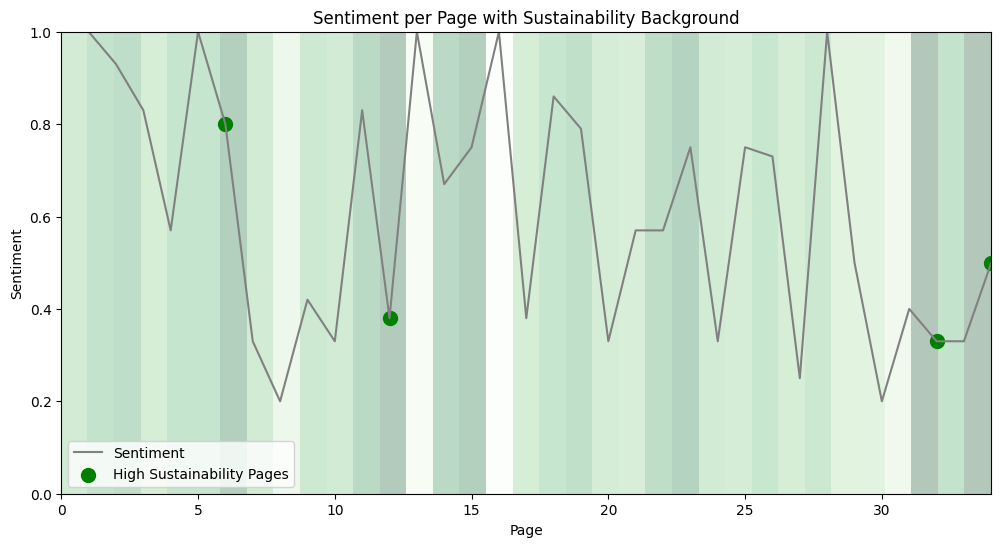

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import interp1d

# Filtra las columnas que te interesan
df = merged[['Page', 'Sentiment', 'sustainability']]

# Asegúrate de que no haya valores nulos en las columnas de interés
df = df.dropna(subset=['Page', 'Sentiment', 'sustainability'])

# Normaliza el valor de sostenibilidad para que esté entre 0 y 1
norm_sustainability = (df['sustainability'] - df['sustainability'].min()) / (df['sustainability'].max() - df['sustainability'].min())

# Crear interpolación para suavizar la sostenibilidad a través de las páginas
page_range = np.linspace(df['Page'].min(), df['Page'].max(), len(df))
interp_sustainability = interp1d(df['Page'], norm_sustainability, kind='linear', fill_value="extrapolate")
smooth_sustainability = interp_sustainability(page_range)

# Calcular el percentil 90 de sostenibilidad
sustainability_threshold = np.percentile(norm_sustainability, 90)

# Filtra las páginas con alta sostenibilidad
high_sustainability_df = df[norm_sustainability >= sustainability_threshold]

# Configura la figura
fig, ax = plt.subplots(figsize=(12, 6))

# Crear el fondo continuo basado en sostenibilidad
ax.imshow(np.tile(smooth_sustainability, (100, 1)), cmap='Greens', aspect='auto', alpha=0.3, extent=(df['Page'].min(), df['Page'].max(), 0, 1))

# Plotea el sentimiento original
ax.plot(df['Page'], df['Sentiment'], color='grey', label='Sentiment')

# Añade puntos rojos en páginas con alta sostenibilidad
ax.scatter(high_sustainability_df['Page'], high_sustainability_df['Sentiment'], color='green', s=100, label='High Sustainability Pages')

# Añade leyendas y etiquetas
ax.set_xlabel('Page')
ax.set_ylabel('Sentiment')
plt.title('Sentiment per Page with Sustainability Background')
plt.legend()
plt.show()


# Calculation: sentiment analysis value for the top 10% sustainable pages

In [ ]:
df = merged
norm_sustainability = (df['sustainability'] - df['sustainability'].min()) / (df['sustainability'].max() - df['sustainability'].min())
sustainability_threshold = np.percentile(norm_sustainability, 90)
high_sustainability_df = df[norm_sustainability >= sustainability_threshold]
round(high_sustainability_df.Sentiment.mean(),3)

In [ ]:
round(high_sustainability_df.Sentiment.mean(),3)

0.503

To save merged in Google sheets

# Zero shot using MiniLM: textattack/albert-base-v2-MNLI

To try also this: ynie/xlnet-base-cased-snli-mnli

# LLAMA2 for the report [deprecated]

More information in this notebook: https://colab.research.google.com/drive/1SQmK0GYz34RGVlOnL5YMkdm7hXD6OjQT?usp=sharing#scrollTo=FoYglrLvmTN1

## Installation and login in Huggingface

To load our desired model, meta-llama/Llama-2-7b-chat-hf, we first need to authenticate ourselves on Hugging Face. This ensures we have the correct permissions to fetch the model.

*   Gain access to the model on Hugging Face: [Link](https://huggingface.co/meta-llama/Llama-2-7b-chat-hf).
*   Use the Hugging Face CLI to login and verify your authentication status.

In [ ]:
!pip install transformers torch accelerate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.4/302.4 kB 4.1 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-many

In [ ]:
!huggingface-cli login


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

    To login, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Token: 
Add token as git credential? (Y/n) n
Token is valid (permission: read).
Your token has been saved to /root/.cache/huggingface/token
Login successful


In [ ]:
!huggingface-cli whoami

charlyspoton


## Loading model and tokenizer

Here, we are preparing our session by loading both the Llama model and its associated tokenizer.

The tokenizer will help in converting our text prompts into a format that the model can understand and process.

In [ ]:
from transformers import AutoTokenizer
import transformers
import torch

model = "meta-llama/Llama-2-7b-chat-hf" # meta-llama/Llama-2-7b-hf

tokenizer = AutoTokenizer.from_pretrained(model, use_auth_token=True)

tokenizer_config.json:   0%|          | 0.00/1.62k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/414 [00:00<?, ?B/s]

## Create the Llama pipeline

We'll set up a pipeline for text generation.

This pipeline simplifies the process of feeding prompts to our model and receiving generated text as output.

Note: This cell takes 2-3 minutes to run

In [ ]:
from transformers import pipeline

llama_pipeline = pipeline(
    "text-generation",  # LLM task
    model=model,
    torch_dtype=torch.float16,
    device_map="auto",
)

config.json:   0%|          | 0.00/614 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/26.8k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/9.98G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/3.50G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/188 [00:00<?, ?B/s]

## Testing Llama and adaptation to our business problem

In [ ]:
def get_llama_response(prompt: str) -> None:
    """
    Generate a response from the Llama model.

    Parameters:
        prompt (str): The user's input/question for the model.

    Returns:
        None: Prints the model's response.
    """
    sequences = llama_pipeline(
        prompt,
        do_sample=True,
        top_k=10,
        num_return_sequences=1,
        eos_token_id=tokenizer.eos_token_id,
        max_length=256,
        truncation = True
    )
    print("Chatbot:", sequences[0]['generated_text'])



prompt = 'I liked "Breaking Bad" and "Band of Brothers". Do you have any recommendations of other shows I might like?\n'
get_llama_response(prompt)

KeyboardInterrupt: 